# MC Dropout Uncertainty Demo

Assumes you have installed this repo in editable mode and can import `uq_reconstruction_demo`.


In [1]:
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import torchvision.transforms as T

from uq_reconstruction_demo.datasets import NoisyImageDataset
from uq_reconstruction_demo.models import ConvAutoencoder, enable_dropout, disable_dropout

device = torch.device("cuda" if torch.cuda.is_available() else (
    "mps" if getattr(torch.backends, 'mps', None) is not None and torch.backends.mps.is_available() else "cpu"
))
device

device(type='mps')

## 1. Set up paths

By default I assume:

- `uq_grayscale_30/` contains your input grayscale PNGs
- `checkpoints/latest.pt` is produced by `train.py`

You can point `data_dir` to any folder of grayscale images.


In [4]:

data_dir = Path("/Users/souvikb/various_analysis/UQ_reconstruction_sample/uq_grayscale_30")
ckpt_path = Path("/Users/souvikb/various_analysis/UQ_reconstruction_sample/checkpoints/latest.pt")
print("Data dir:", data_dir.resolve())
print("Checkpoint:", ckpt_path.resolve())
data_dir.exists(), ckpt_path.exists()

Data dir: /Users/souvikb/various_analysis/UQ_reconstruction_sample/uq_grayscale_30
Checkpoint: /Users/souvikb/various_analysis/UQ_reconstruction_sample/checkpoints/latest.pt


(True, True)

## 2. Build dataset and visualize a degraded vs clean pair

We use the same `NoisyImageDataset` as in `train.py`, which returns `(degraded, clean)` tensors in `[0, 1]`.


Dataset size: 30
Image shape: torch.Size([1, 128, 128])


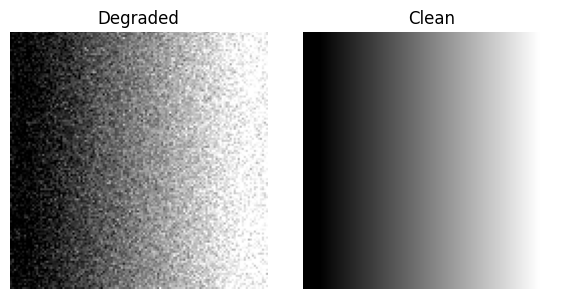

In [5]:
transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
])

dataset = NoisyImageDataset(str(data_dir), transform=transform)
print("Dataset size:", len(dataset))

degraded, clean = dataset[0]
print("Image shape:", degraded.shape)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(degraded[0], cmap="gray")
axes[0].set_title("Degraded")
axes[0].axis("off")

axes[1].imshow(clean[0], cmap="gray")
axes[1].set_title("Clean")
axes[1].axis("off")

plt.tight_layout()
plt.show()

## 3. Load the trained autoencoder

We recreate the `ConvAutoencoder` with the same dropout probability as in training and load weights from `latest.pt`.


In [6]:
dropout_p = 0.1  # must match training
model = ConvAutoencoder(dropout_p=dropout_p).to(device)

ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()
model

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout2d(p=0.1, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Dropout2d(p=0.1, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Sigmoid()
  )
)

## 4. Deterministic reconstruction (no MC Dropout)

First, we look at a single forward pass with dropout disabled in the encoder. This shows the baseline reconstruction.


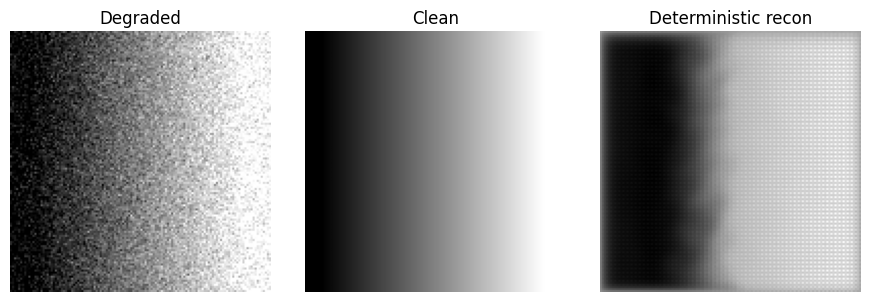

In [10]:
from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=1, shuffle=False)
degraded_batch, clean_batch = next(iter(loader))

degraded_batch = degraded_batch.to(device)
clean_batch = clean_batch.to(device)

disable_dropout(model)
with torch.no_grad():
    recon_det = model(degraded_batch)

degraded_np = degraded_batch[0, 0].cpu().numpy()
clean_np = clean_batch[0, 0].cpu().numpy()
recon_np = recon_det[0, 0].cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for ax in axes:
    ax.axis("off")

axes[0].imshow(degraded_np, cmap="gray")
axes[0].set_title("Degraded")

axes[1].imshow(clean_np, cmap="gray")
axes[1].set_title("Clean")

axes[2].imshow(recon_np, cmap="gray")
axes[2].set_title("Deterministic recon")

plt.tight_layout()
plt.show()

## 5. MC Dropout: mean reconstruction and pixel-wise variance

Now we enable dropout in the encoder during inference and run multiple stochastic passes to estimate the predictive mean and variance.


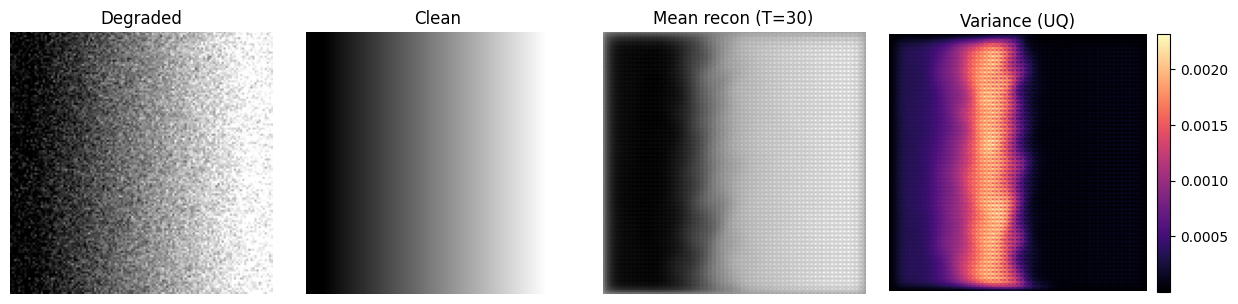

In [11]:
import torch

def mc_reconstruct(model, degraded, mc_samples: int = 30):
    model.eval()
    enable_dropout(model)

    preds = []
    with torch.no_grad():
        for _ in range(mc_samples):
            recon = model(degraded)
            preds.append(recon.unsqueeze(0))  # (1, B, C, H, W)

    preds = torch.cat(preds, dim=0)  # (T, B, C, H, W)
    mean = preds.mean(dim=0)
    var = preds.var(dim=0, unbiased=False)

    disable_dropout(model)
    return mean, var

mc_samples = 30
mean_mc, var_mc = mc_reconstruct(model, degraded_batch, mc_samples=mc_samples)

mean_np = mean_mc[0, 0].cpu().numpy()
var_np = var_mc[0, 0].cpu().numpy()

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for ax in axes:
    ax.axis("off")

axes[0].imshow(degraded_np, cmap="gray")
axes[0].set_title("Degraded")

axes[1].imshow(clean_np, cmap="gray")
axes[1].set_title("Clean")

axes[2].imshow(mean_np, cmap="gray")
axes[2].set_title(f"Mean recon (T={mc_samples})")

im3 = axes[3].imshow(var_np, cmap="magma")
axes[3].set_title("Variance (UQ)")

plt.tight_layout()
plt.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)
plt.show()